In [1]:
#coding:utf-8

import keras
from keras import Input, Model
from keras.layers import Embedding, Dense, Dropout, Bidirectional, CuDNNLSTM
import matplotlib.pyplot as plt
import itertools

Using TensorFlow backend.


In [2]:
VECTOR_DIR = 'word2vec/word2vec.model.bin'
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 250
VALIDATION_SPLIT = 0.16
TEST_SPLIT = 0.2
max_features = 5000
batch_size = 32
embedding_dims = 250
epochs = 10
n_classes = ["Oph","Uro","D","Ortho","GYN","P","S","G&H"]

In [3]:

print ('(1) load texts...')
train_texts = open('data/train_contents.txt').read().split('\n')
train_labels = open('data/train_labels.txt').read().split('\n')
test_texts = open('data/test_contents.txt').read().split('\n')
test_labels = open('data/test_labels.txt').read().split('\n')
all_texts = train_texts + test_texts
all_labels = train_labels + test_labels

(1) load texts...


In [4]:
print ('(2) doc to var...')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np


(2) doc to var...


In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_texts)
sequences = tokenizer.texts_to_sequences(all_texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(all_labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 51199 unique tokens.
Shape of data tensor: (24000, 300)
Shape of label tensor: (24000, 9)


In [6]:
print ('(3) split data set...')
p1 = 15000
p2 = -800
x_train = data[:p1]
y_train = labels[:p1]
x_val = data[p1:p2]
y_val = labels[p1:p2]
x_test = data[p2:]
y_test = labels[p2:]

print ('train docs: '+str(len(x_train)))
print ('val docs: '+str(len(x_val)))
print ('test docs: '+str(len(x_test)))

from mpu.math import argmax
def one_hot2indices(one_hots):
    indices = []
    for one_hot in one_hots:
        indices.append(argmax(one_hot))
    return indices

(3) split data set...
train docs: 15000
val docs: 8200
test docs: 800


In [45]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [46]:
print ('(5) training model...')
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, Embedding
from keras.models import Sequential

model = Sequential()
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(250))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(labels.shape[1], activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
print (model.metrics_names)
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=200)
model.save('models/8_word_vector_lstm.h5')


(5) training model...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 300, 250)          12800000  
_________________________________________________________________
lstm_6 (LSTM)                (None, 250)               501000    
_________________________________________________________________
dense_9 (Dense)              (None, 500)               125500    
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 9)                 4509      
Total params: 13,431,009
Trainable params: 13,431,009
Non-trainable params: 0
_________________________________________________________________
['loss', 'acc']
Train on 15000 samples, validate on 8200 samples
Epoch 1/10
15000/1500

In [7]:
from keras.models import load_model
model = load_model('models/8_word_vector_lstm.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [8]:
def plot_confusion_matrix(cm, n_classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(10, 8)) 
    fig = plt.rcParams['font.size'] = 15
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(n_classes))
    plt.xticks(tick_marks, n_classes, rotation=45)
    plt.yticks(tick_marks, n_classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

(6) testing model...
accuracy:0.94625
[[100   0   0   0   0   0   0   0]
 [  0  99   0   0   0   0   1   0]
 [  0   0 101   0   0   0   0   0]
 [  0   0   0  99   1   0   0   0]
 [  0   2   0   0  97   0   0   0]
 [  1   0   0   0   0  98   0   0]
 [  0   1   1   1   1   0  92   4]
 [  1  10   2   0   5   1  11  71]]
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       100
           2       0.88      0.99      0.93       100
           3       0.97      1.00      0.99       101
           4       0.99      0.99      0.99       100
           5       0.93      0.98      0.96        99
           6       0.99      0.99      0.99        99
           7       0.88      0.92      0.90       100
           8       0.95      0.70      0.81       101

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.94       800
weighted avg       0.95      0.95      0.94       800



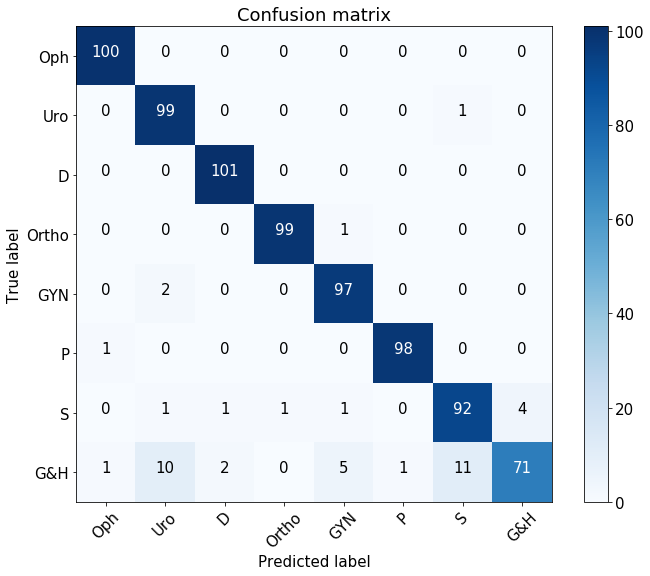

In [9]:
print('(6) testing model...')
from sklearn.metrics import accuracy_score

preds = model.predict(x_test)
y_true = one_hot2indices(y_test)
y_preds = one_hot2indices(preds)
print("accuracy:"+ str(accuracy_score(y_true, y_preds)))

from sklearn import metrics
print(metrics.confusion_matrix(y_true, y_preds))

from sklearn.metrics import classification_report
print(classification_report(y_pred=y_preds, y_true=y_true))


cm = metrics.confusion_matrix(y_true,y_preds)
plot_confusion_matrix(cm, n_classes,
                      title='Confusion matrix')